In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [2]:
benchmark_results = []
for path in glob.glob('../benchmarks/2020-12-09-euler-plan-batch-test/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,micros_input,micros_precompute,micros_until_len,micros_edit_script
11,28,addremove,60000,0.25,0.0,zipf,0,2,sequential_frontier_simd,NaN,11282,0,1589718,0
22,57,addremove,100000,0.50,0.0,zipf,0,1,mpi_no_master_frontier_simd,128.0,2280281,0,211322,0
78,45,add,80000,0.75,0.0,zipf,0,0,mpi_priority_frontier_simd,8.0,22423,0,1708403,0
148,71,add,120000,0.75,0.0,zipf,0,1,mpi_no_master_frontier_simd,8.0,34283,0,6081254,0
150,71,add,120000,0.75,0.0,zipf,0,0,mpi_priority_frontier,16.0,27290,0,2222,0


In [3]:
def prepare_plot_data(filter_cb, index):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

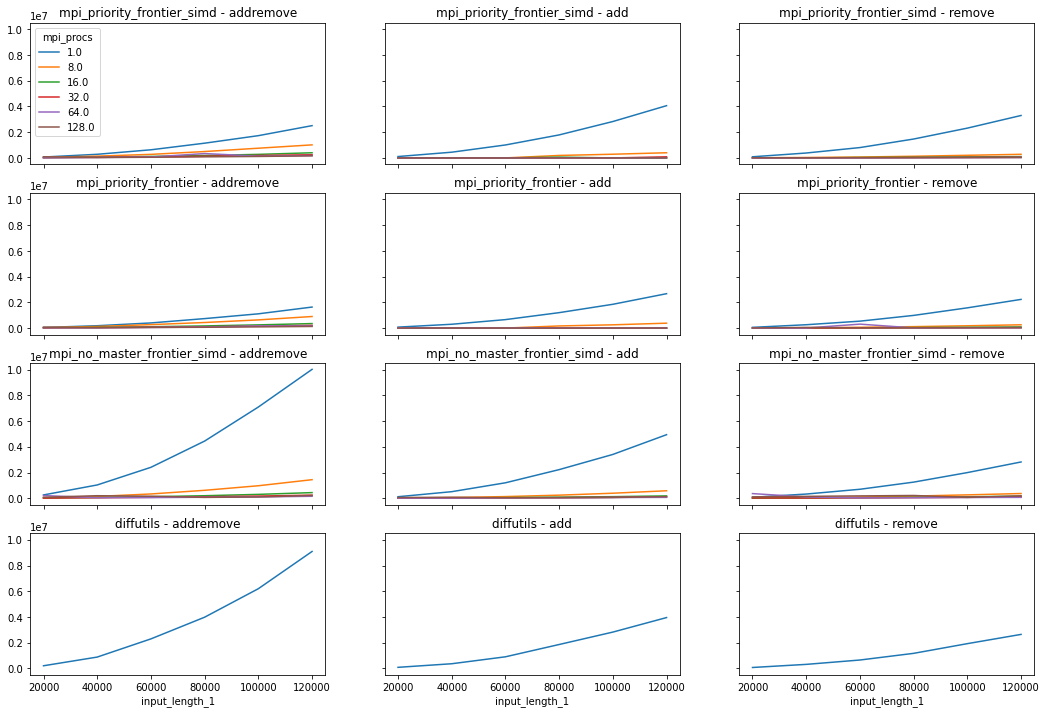

In [8]:
fig, ax = plt.subplots(4, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd', 'diffutils']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)],
            'input_length_1',
        )
        temp = temp.droplevel('diff_program')
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');

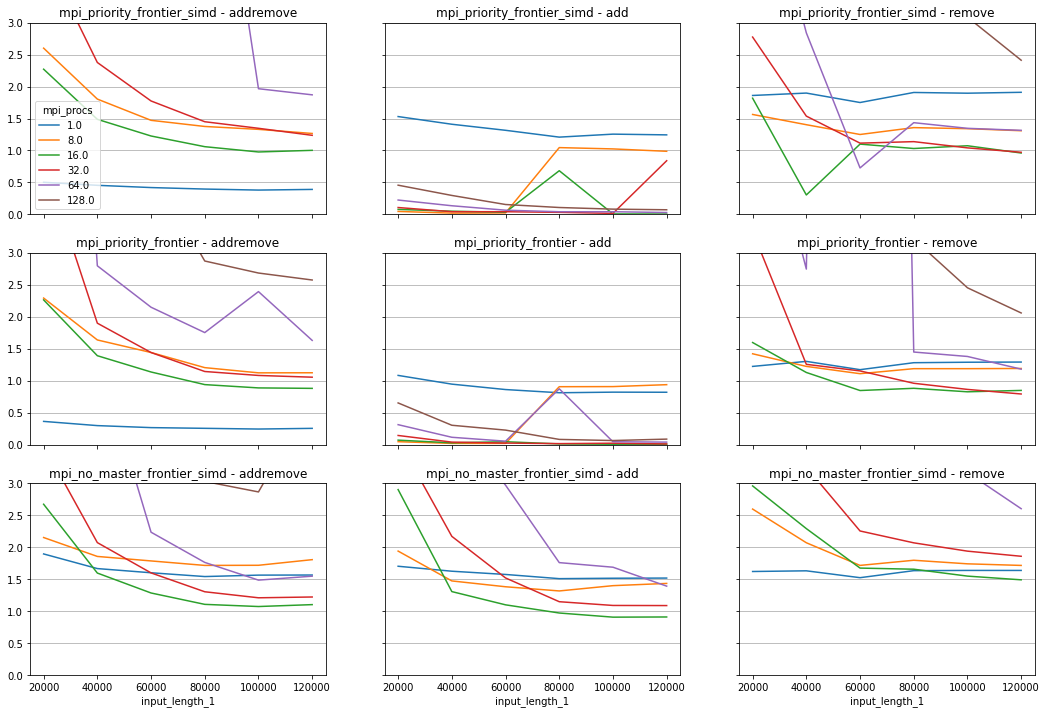

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == 0.25) & (temp['input_chunkiness'] == 0)]
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs('sequential_frontier_simd', level='diff_program').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 3), grid=True);
        ax[diff_program_i][input_strategy_i].grid(axis='x')

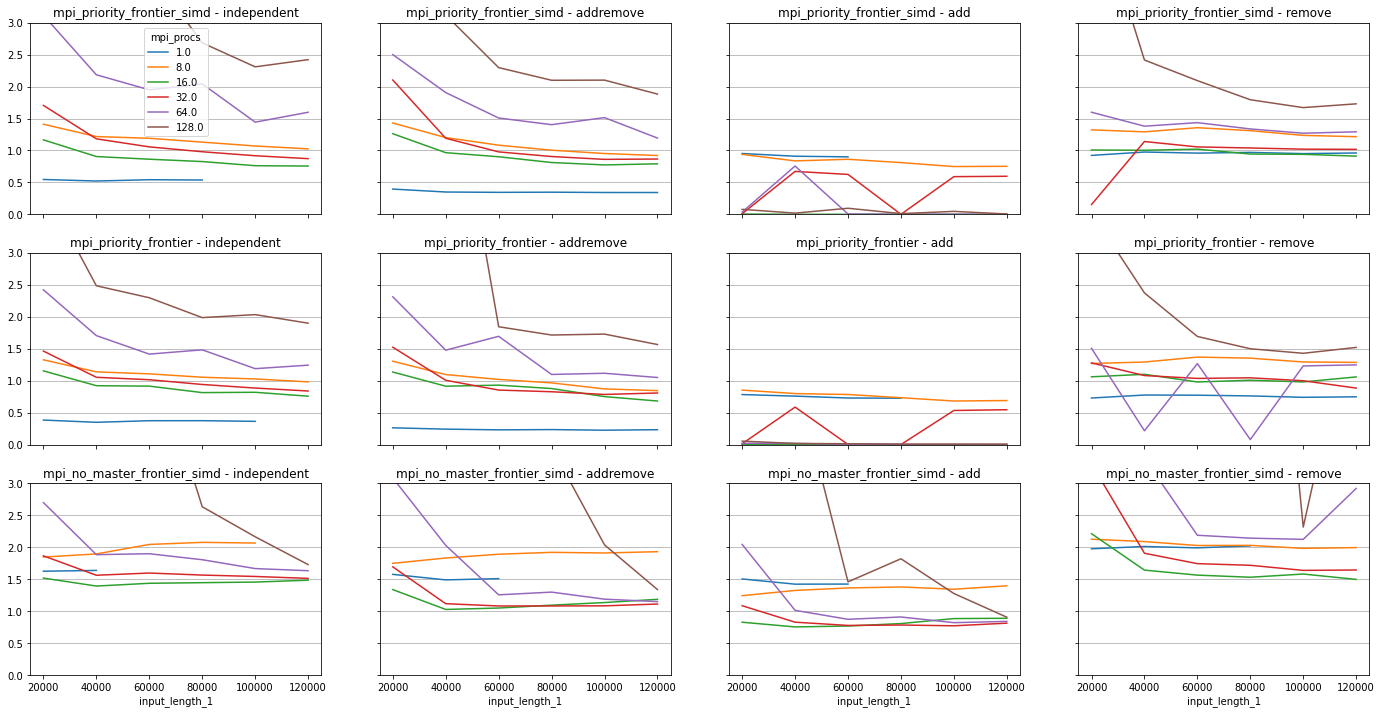

In [14]:
fig, ax = plt.subplots(3, 4, figsize=(24, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier_simd', 'mpi_priority_frontier', 'mpi_no_master_frontier_simd']):
    for input_strategy_i, input_strategy in enumerate(['independent', 'addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == 0)]
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs('sequential_frontier_simd', level='diff_program').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 3));
        ax[diff_program_i][input_strategy_i].grid(axis='y')